In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [2]:
ambient_data = pd.read_excel("../resources/aap_bod_may2018_v0.xlsx", sheet_name=1)
air_pollution = pd.read_csv('../resources/pm10.csv')

In [3]:
# define functions
def categorize_features(df, features):
    df_copy = df.copy()
    categories = {}
    for feature in features:
        df_copy[feature] = pd.Categorical(df_copy[feature])
        df_copy['{}_code'.format(feature)] = df_copy[feature].cat.codes
        categories.update({feature: list(df_copy[feature].cat.categories)})
        
    return df_copy.drop(features, axis=1), categories

def normalize_data(df, features):
    df_copy = df.copy()
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df_copy[features])
    df_copy[features] = scaled
    return df_copy

def make_dummy_variables(df, features):
    df_copy = df.copy()
    dummies = pd.get_dummies(df_copy[features])
    df_copy = pd.concat([df_copy, dummies], axis=1)
    return df_copy.drop(features, axis=1)

def plot_features_importance(x, y):
    plt.figure(figsize=(18,8))
    plt.scatter(x, y)
    plt.xticks(rotation=90);

In [4]:
ambient_data = ambient_data.drop(['year', 'status', 'cause2015', 'whoname'], axis=1)
grouped = ambient_data.groupby('iso3').apply(lambda x :x.isna().sum())
countries_to_remove = list(grouped[grouped['AB_AAP_pc_upper_AS']>0].index)
ambient_data = ambient_data.loc[~ambient_data['iso3'].isin(countries_to_remove)]

In [5]:
ambient_data.head()

,iso3,causename2,sex,age,health_outcome,AB_AAP_mean,AB_AAP_lower,AB_AAP_upper,AB_AAP_pc_mean,AB_AAP_pc_upper,AB_AAP_pc_lower,AB_AAP_pc_mean_AS,AB_AAP_pc_upper_AS,AB_AAP_pc_lower_AS
0,AFG,ALRI,b,0,dths,4245.812988,3289.411133,5218.406250,12.251298,15.057716,9.491599,7.160412,8.800656,5.547474
1,AFG,Lung cancer,b,25+,dths,245.479962,160.320648,333.016693,0.708333,0.960920,0.462605,1.780666,2.415641,1.162936
2,AFG,IHD,b,25+,dths,7271.271439,6228.604980,8333.379883,20.981260,24.045977,17.972647,58.344009,66.866272,49.977753
3,AFG,Stroke,b,25+,dths,2743.734619,2329.802002,3185.718750,7.917049,9.192394,6.722646,22.796988,26.469320,19.357727
4,AFG,COPD,b,25+,dths,1243.574786,750.883606,1776.479858,3.588336,5.126034,2.166675,12.026935,17.180798,7.261990


In [6]:
common_countries = np.intersect1d(ambient_data.iso3, air_pollution.iso3)
ambient_data = ambient_data.loc[ambient_data['iso3'].isin(common_countries)]

In [7]:
df = pd.merge(ambient_data, air_pollution[['iso3', 'pm10']], how='left')

In [8]:
df.head()

,iso3,causename2,sex,age,health_outcome,AB_AAP_mean,AB_AAP_lower,AB_AAP_upper,AB_AAP_pc_mean,AB_AAP_pc_upper,AB_AAP_pc_lower,AB_AAP_pc_mean_AS,AB_AAP_pc_upper_AS,AB_AAP_pc_lower_AS,pm10
0,ALB,ALRI,b,0,dths,7.827327,3.980751,12.417084,0.267478,0.424320,0.136031,0.389436,0.617791,0.198056,25.0
1,ALB,Lung cancer,b,25+,dths,122.718251,65.231644,193.440720,4.193566,6.610316,2.229116,2.763597,4.356256,1.469007,25.0
2,ALB,IHD,b,25+,dths,994.124942,732.884216,1261.978882,33.971546,43.124733,25.044346,22.224754,28.212923,16.384430,25.0
3,ALB,Stroke,b,25+,dths,560.113067,348.042389,943.241699,19.140356,32.232746,11.893412,12.219035,20.577103,7.592649,25.0
4,ALB,COPD,b,25+,dths,106.775162,51.290440,176.157532,3.648754,6.019710,1.752713,2.275742,3.754516,1.093174,25.0


In [9]:
# get dummies
df_linear = make_dummy_variables(df.drop('iso3', axis=1), ['causename2', 'sex', 'age', 'health_outcome'])

In [10]:
df_norm_linear = normalize_data(df_linear, ['AB_AAP_mean', 'AB_AAP_lower', 'AB_AAP_upper', 'AB_AAP_pc_mean', 
                                            'AB_AAP_pc_upper', 'AB_AAP_pc_lower', 'AB_AAP_pc_mean_AS', 
                                            'AB_AAP_pc_upper_AS', 'AB_AAP_pc_lower_AS', 'pm10'])

In [11]:
df_norm_linear.head()

,AB_AAP_mean,AB_AAP_lower,AB_AAP_upper,AB_AAP_pc_mean,AB_AAP_pc_upper,AB_AAP_pc_lower,AB_AAP_pc_mean_AS,AB_AAP_pc_upper_AS,AB_AAP_pc_lower_AS,pm10,...,causename2_Stroke,sex_b,sex_f,sex_m,age_0,age_25+,age_All ages (ALRI),age_All ages (AP),health_outcome_daly,health_outcome_dths
0,2.320733e-07,1.328002e-07,3.276842e-07,0.000080,0.000109,0.000048,0.000098,0.000134,0.000059,0.044892,...,0,1,0,0,1,0,0,0,0,1
1,3.638487e-06,2.176167e-06,5.104860e-06,0.001254,0.001698,0.000787,0.000697,0.000944,0.000438,0.044892,...,0,1,0,0,0,1,0,0,0,1
2,2.947492e-05,2.444946e-05,3.330336e-05,0.010156,0.011075,0.008847,0.005607,0.006114,0.004885,0.044892,...,0,1,0,0,0,1,0,0,0,1
3,1.660686e-05,1.161090e-05,2.489195e-05,0.005722,0.008278,0.004202,0.003083,0.004460,0.002264,0.044892,...,1,1,0,0,0,1,0,0,0,1
4,3.165789e-06,1.711080e-06,4.648760e-06,0.001091,0.001546,0.000619,0.000574,0.000814,0.000326,0.044892,...,0,1,0,0,0,1,0,0,0,1


In [13]:
linear_regression = LinearRegression()
x_lin = df_norm_linear.drop('pm10', axis=1)
y = df_norm_linear['pm10']
linear_regression.fit(x_lin, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

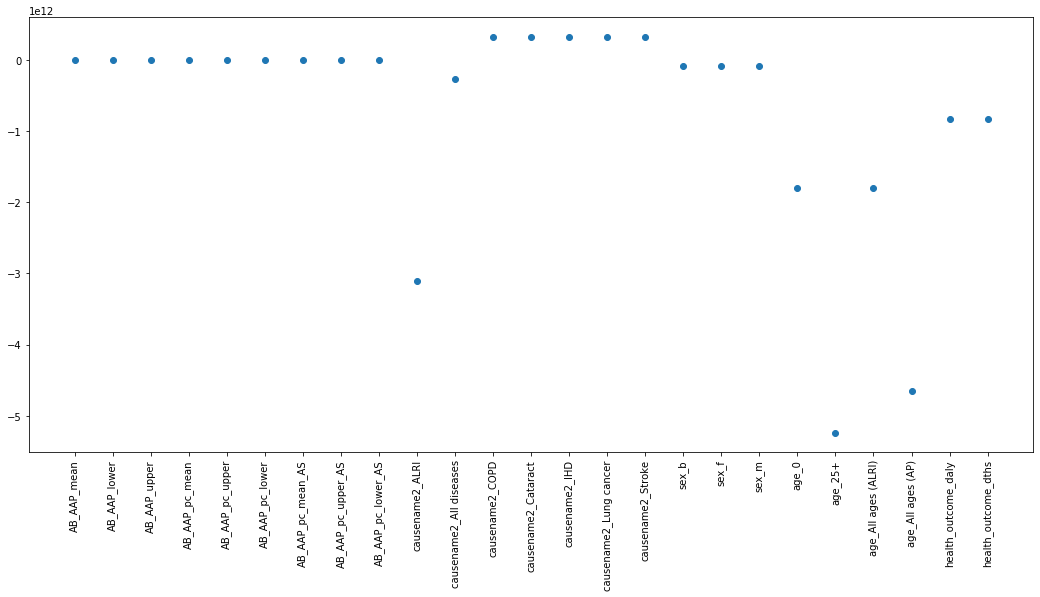

In [14]:
plot_features_importance(x_lin.columns, linear_regression.coef_.ravel())

In [15]:
random_forest = RandomForestRegressor(n_estimators=20)
x_tree, categories = categorize_features(df.drop('iso3', axis=1), ['causename2', 'sex', 'age', 'health_outcome'])
x_tree = x_tree.drop('pm10', axis=1)
random_forest.fit(x_tree, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=20,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

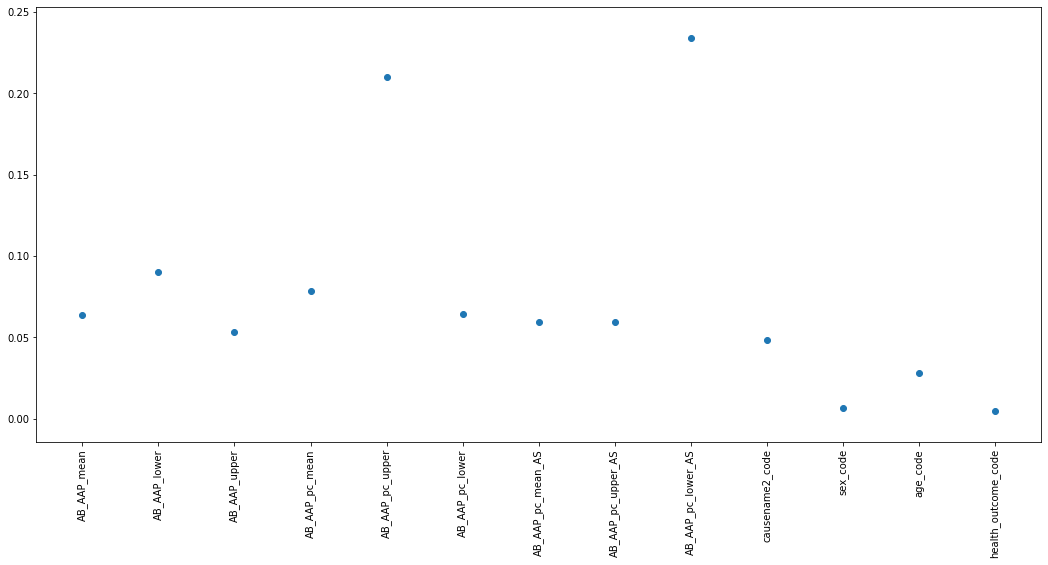

In [17]:
plot_features_importance(x_tree.columns, random_forest.feature_importances_)
